## Load data and corelation check

In [3]:
import pandas as pd
from config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

df = pd.read_csv(CSV_FILEPATH_MODEL_READY_DATA_PRICE)
display(df.head())

,points,vintage,designation_fe,winery_te,region_1_te,variety_te,province_te,country=Argentina,country=Armenia,country=Australia,...,taster_name=Matt Kettmann,taster_name=Michael Schachner,taster_name=Mike DeSimone,taster_name=Paul Gregutt,taster_name=Roger Voss,taster_name=Sean P. Sullivan,taster_name=Susan Kostrzewa,taster_name=Virginie Boone,taster_name=__MISSING__,price
0,87,2013.0,0.000008,30.116707,37.998042,23.197256,28.005311,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,87,2011.0,0.000015,30.852118,27.113411,24.938141,29.612891,0,0,0,...,0,0,0,0,1,0,0,0,0,15.0
2,87,2013.0,0.288257,24.846995,35.182556,23.028626,36.555187,0,0,0,...,0,0,0,1,0,0,0,0,0,14.0
3,87,2013.0,0.000062,26.868550,45.221130,31.681079,33.181793,0,0,0,...,0,0,0,0,0,0,0,0,0,13.0
4,87,2012.0,0.000008,29.947457,35.096027,47.183510,36.574418,0,0,0,...,0,0,0,1,0,0,0,0,0,65.0


In [5]:
display("missing values in each column in percent:")
missing_percent = (df.isna().sum() / len(df)) * 100
display(missing_percent[missing_percent > 0])
display("missing values in each column in count:")
missing_count = df.isna().sum()
display(missing_count[missing_count > 0])
display(f"Number of rows where both 'price' and 'vintage' are missing: {df[df['price'].isna() & df['vintage'].isna()].shape[0]}")

'missing values in each column in percent:'

vintage    3.563103
price      6.921544
dtype: float64

'missing values in each column in count:'

vintage    4631
price      8996
dtype: int64

"Number of rows where both 'price' and 'vintage' are missing: 476"

In [6]:
df_without_missing_price_and_vintage = df.dropna(subset=['price', 'vintage'])

### Corelation check

#### Corelation values

In [7]:
def print_corelations_and_return_realiable_features(df):
    corelation_threshold = 0.05

    correlations = df.corr()['price'].sort_values(ascending=False)
    correlations = correlations.drop('price', errors='ignore')

    pd.set_option('display.max_rows', None)
    correlations_df = correlations.to_frame(name='Correlation')
    correlations_df = correlations_df[correlations_df['Correlation'].abs() > corelation_threshold]
    realiable_features = correlations_df.index.tolist()

    display(len(realiable_features), correlations_df)
    pd.reset_option('display.max_rows')
    return realiable_features, correlations

realiable_features_unscaled, correlations = print_corelations_and_return_realiable_features(df_without_missing_price_and_vintage)

11

,Correlation
winery_te,0.559231
region_1_te,0.486332
points,0.414945
province_te,0.284232
variety_te,0.280404
taster_name=Virginie Boone,0.081293
taster_name=Kerin O’Keefe,0.050896
country=Chile,-0.070608
designation_fe,-0.085747
taster_name=Michael Schachner,-0.091987


#### Lets see how logarithmic scale for price will change the correlations

In [8]:
df_without_missing_price_and_vintage_scaled = df_without_missing_price_and_vintage.copy()
df_without_missing_price_and_vintage_scaled['price'] =  np.log1p(df_without_missing_price_and_vintage_scaled['price'])
realiable_features_scaled, correlations_scaled = print_corelations_and_return_realiable_features(df_without_missing_price_and_vintage_scaled)


21

,Correlation
points,0.610172
region_1_te,0.589405
winery_te,0.589392
variety_te,0.440790
province_te,0.403565
country=US,0.158831
taster_name=Virginie Boone,0.158075
taster_name=Kerin O’Keefe,0.087500
country=Italy,0.080332
taster_name=Matt Kettmann,0.080084


#### Saving data for future use

In [9]:
df_to_save = df_without_missing_price_and_vintage[realiable_features_unscaled + ['price']]
df_to_save.to_csv('data/df_without_missing_price_and_vintage_for_price_regression_not_scaled.csv', index=False)

df_to_save = df_without_missing_price_and_vintage[realiable_features_scaled + ['price']]
df_to_save['price'] = np.log1p(df_to_save['price'])
df_to_save.to_csv('data/df_without_missing_price_and_vintage_for_price_regression_scaled.csv', index=False)

new_df = df[realiable_features_unscaled + ['price']]
new_df.to_csv('data/df_without_missing_price_and_vintage_for_price_regression_to_fill.csv', index=False)


def preprocess(df):
    df = df.dropna(subset=['price', 'vintage'])
    df['price'] = np.log1p(df_to_save['price'])
    return df


C:\Users\Milosz\AppData\Local\Temp\ipykernel_26524\1007255454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save['price'] = np.log1p(df_to_save['price'])


#### Corelation plots (For unscaled data)

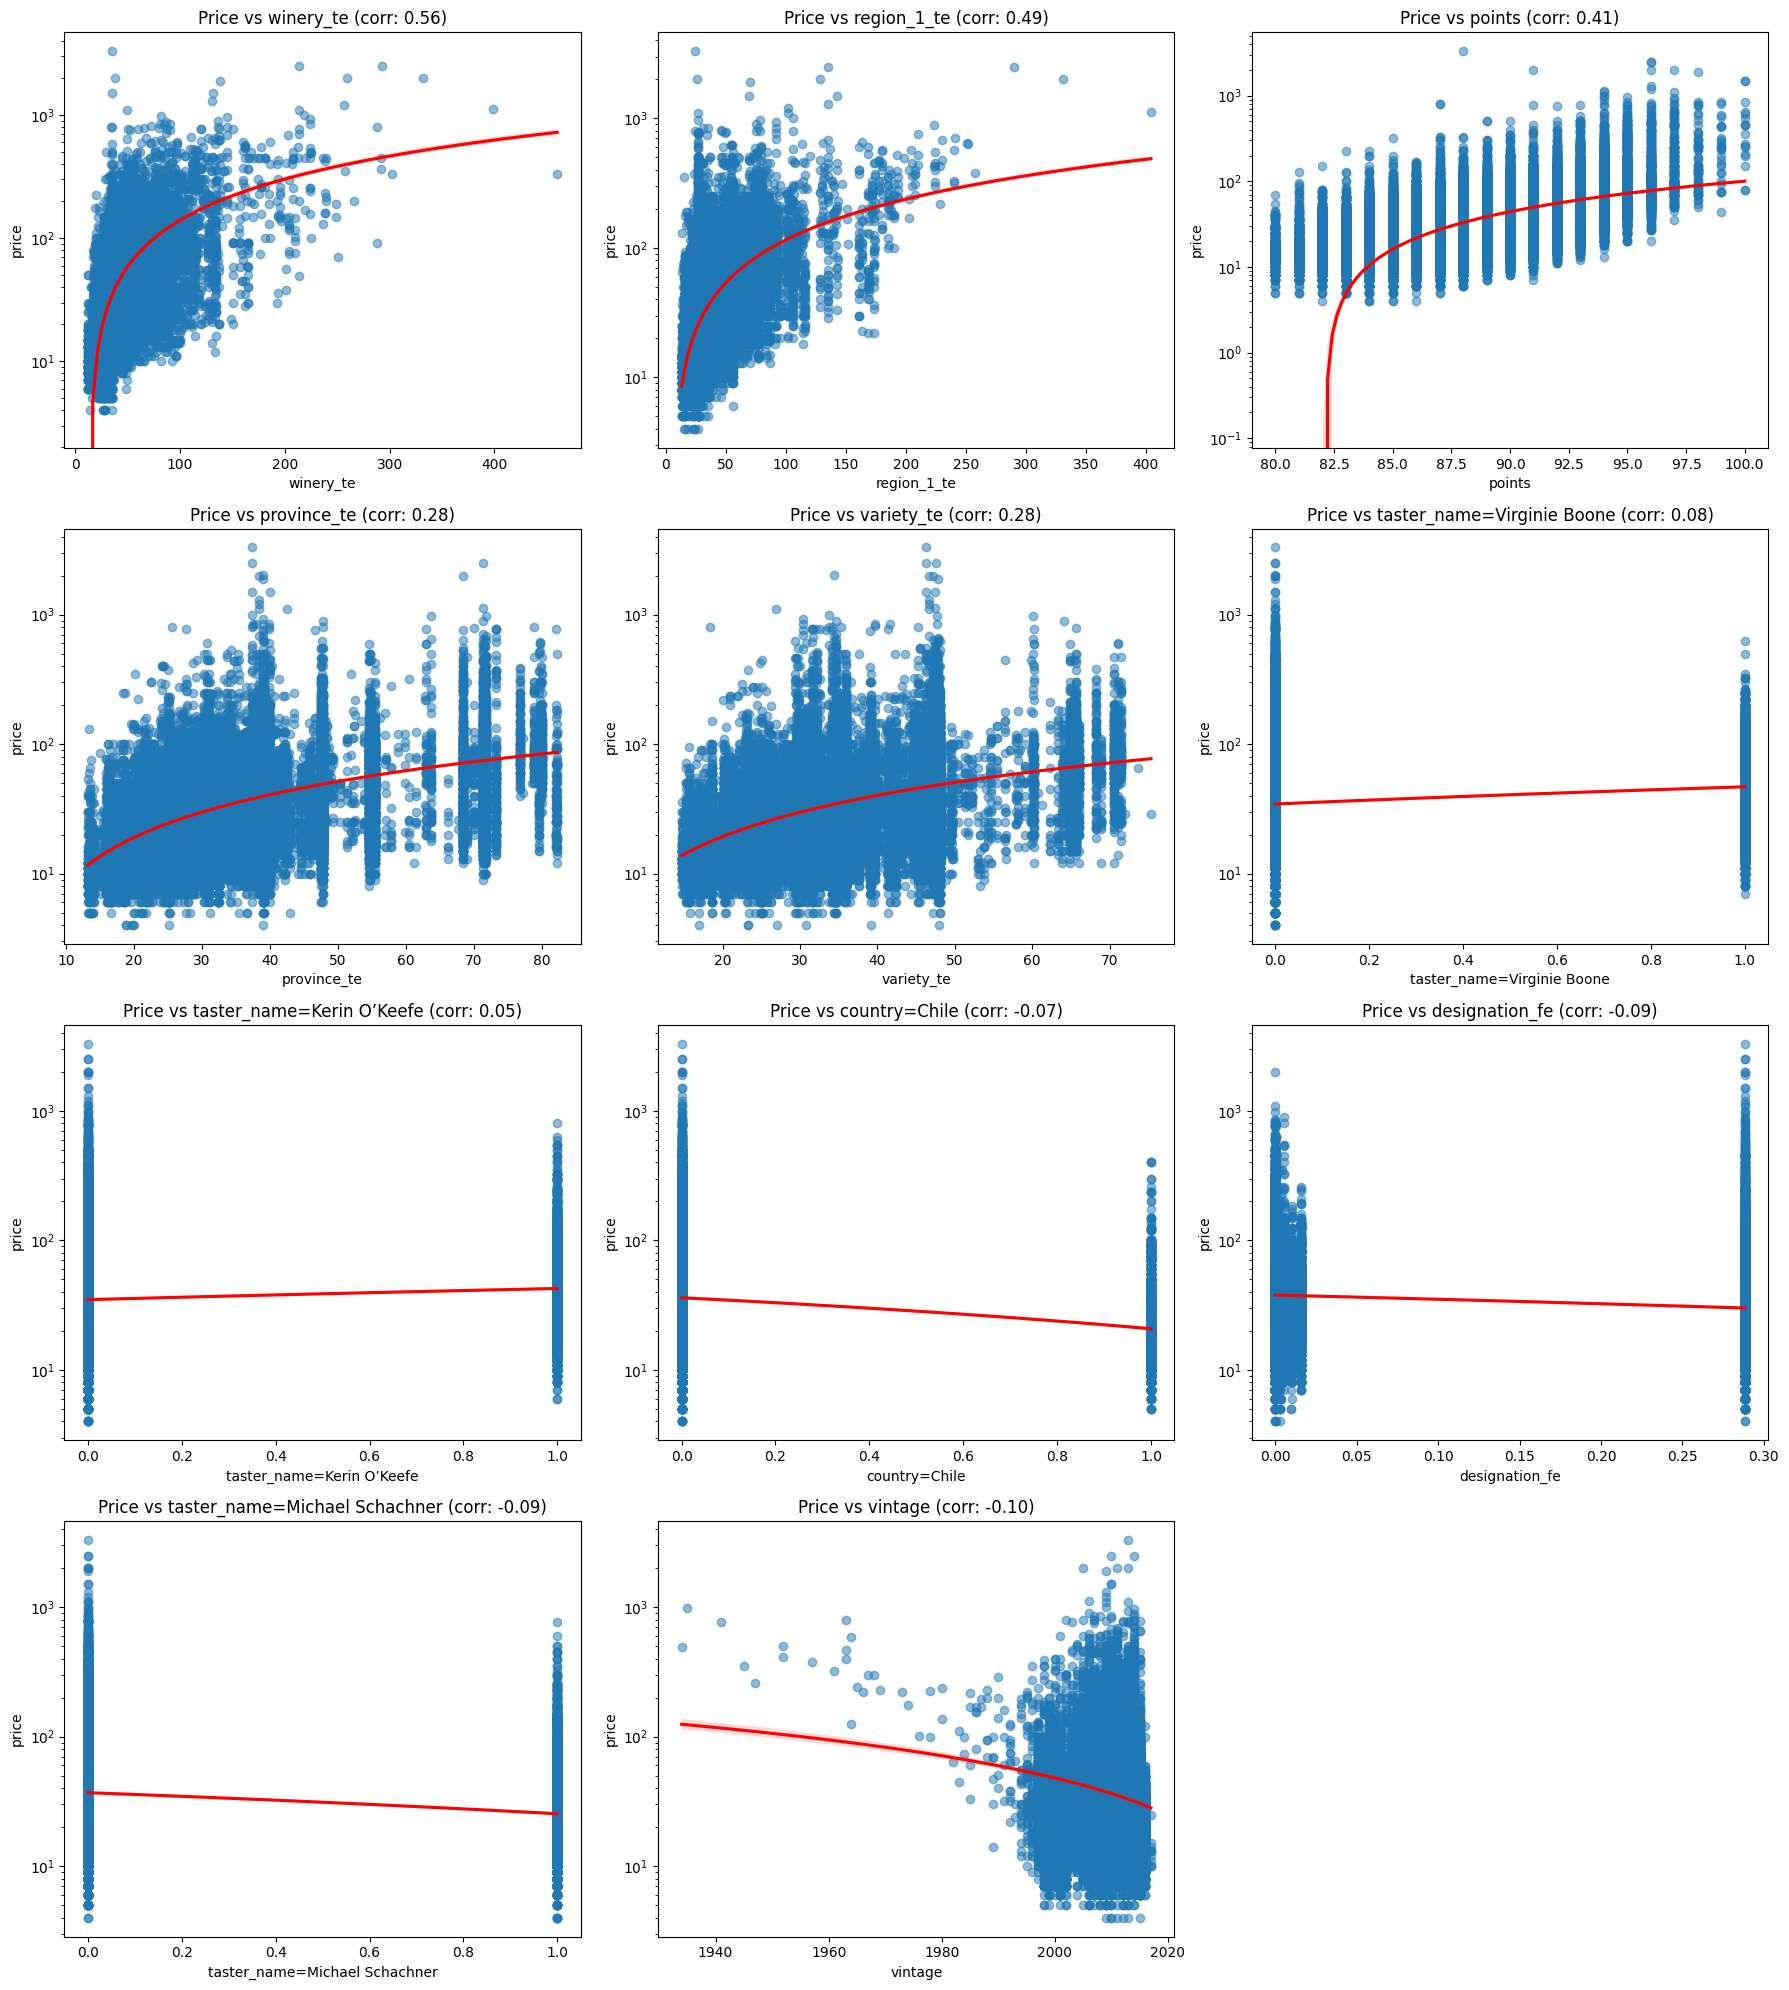

In [7]:
realiable_features = realiable_features_unscaled

n_cols = 3
n_rows = math.ceil(len(realiable_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(realiable_features):
    plot = sns.regplot(
        x=col,
        y='price',
        data=df_without_missing_price_and_vintage,
        ax=axes[i],
        scatter_kws={'alpha':0.5}, 
        line_kws={'color': 'red'} 
    )
    
    axes[i].set_yscale('log')
    axes[i].set_title(f"Price vs {col} (corr: {correlations[col]:.2f})")

# Ukrywamy puste wykresy
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The scatter plots illustrate the relationship between various features and price. Notably, vintage exhibits a negligible correlation (~ -0.1), suggesting that for this market, an item’s premium status carries more weight than its age or 'vintage' year.

#### Corelation plots (For scaled data)

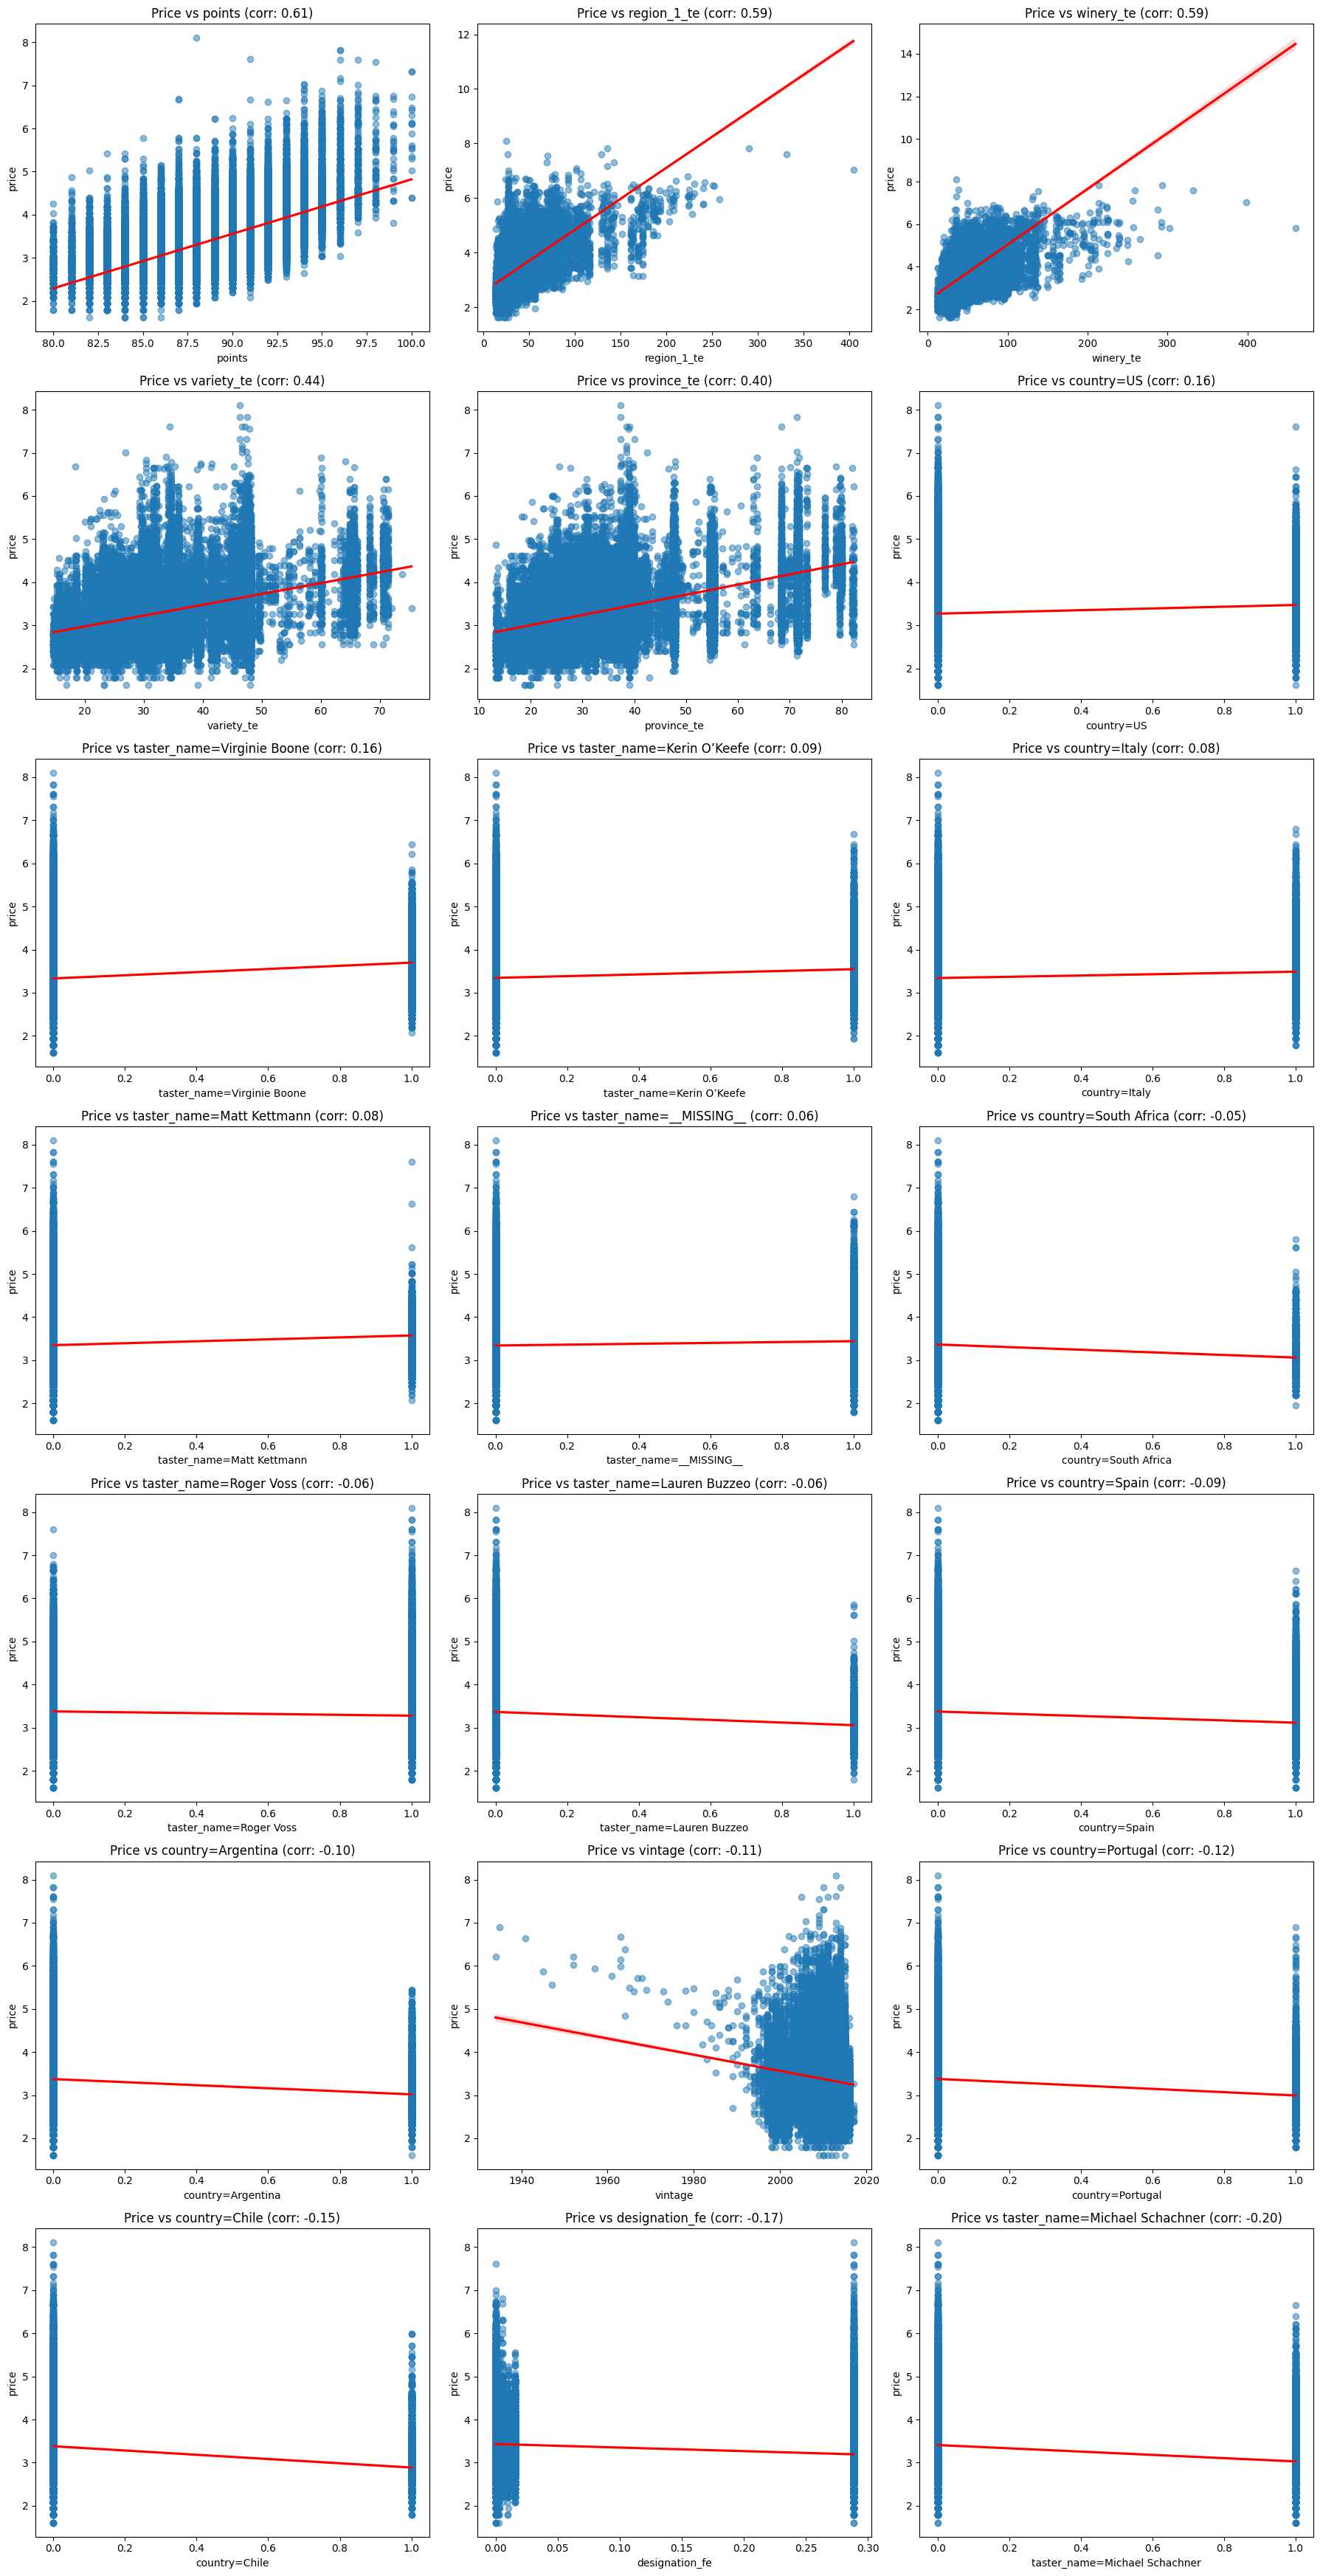

In [8]:
realiable_features = realiable_features_scaled

n_cols = 3
n_rows = math.ceil(len(realiable_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(realiable_features):
    plot = sns.regplot(
        x=col,
        y='price',
        data=df_without_missing_price_and_vintage_scaled,
        ax=axes[i],
        scatter_kws={'alpha':0.5}, 
        line_kws={'color': 'red'} 
    )
    
    axes[i].set_title(f"Price vs {col} (corr: {correlations_scaled[col]:.2f})")

# Ukrywamy puste wykresy
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Using Linear Regression to predict price

## Without embeddings

In [10]:
from review_prediction_model_using_regression import all_results
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

target_col = 'price'
def make_regression_model(embeddings_filepath, csv_filepath, doIUseEmbeddings = True):
    if(doIUseEmbeddings):
        df = load_embeddings_and_data(embeddings_filepath, csv_filepath, isFirstColumnIndex=False)
        df = preprocess(df)
    else:
        df = pd.read_csv(csv_filepath)

    nan_stats = df.isnull().mean(axis=0)
    columns_to_drop = nan_stats.index[nan_stats > 0]

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

    use_columns = train_df.select_dtypes(include="number").columns
    use_columns = use_columns.drop(target_col, errors="ignore")
    use_columns = use_columns.drop(columns_to_drop, errors="ignore")

    X = train_df[use_columns]
    y = train_df[target_col]
    
    X.columns = X.columns.astype(str)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)

    print("Intercept: ", model.intercept_)
    print("Coefficients: ", model.coef_)

    X_test = test_df[use_columns]
    X_test.columns = X_test.columns.astype(str)
    y_test = test_df[target_col]
    y_pred = model.predict(X_test)

    rsc = model.score(X_test, y_test)
    mse = skm.mean_squared_error(y_test, y_pred)
    mape = skm.mean_absolute_percentage_error(y_test, y_pred)
    mae = skm.mean_absolute_error(y_test, y_pred)

    all_results = [dict(variant="1-basic", MSE=mse, MAE=mae, MAPE=mape, Rsq=rsc)]
    print(pd.DataFrame(all_results))

    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    
    max_val = max(max(y_test), max(y_pred))
    min_val = min(min(y_test), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Price')
    plt.show()

    return model

Intercept:  927.9645636221153
Coefficients:  [  1.10662313   0.6097381    2.56053274  -0.19335029   0.18104077
   0.1003701   -0.05809584   0.89256971 -12.05067844   2.23948238
  -0.58631034]
   variant         MSE       MAE      MAPE       Rsq
0  1-basic  942.890131  13.24728  0.429584  0.414401


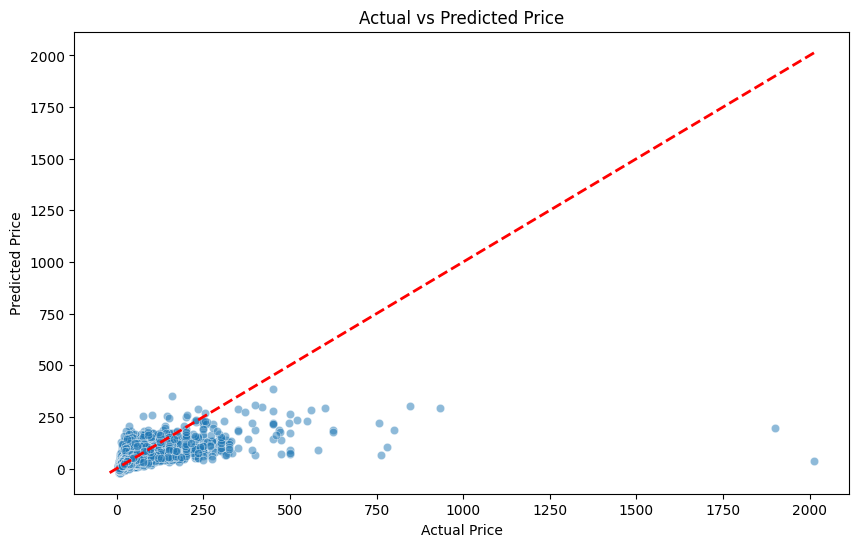

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [10]:
make_regression_model("", CSV_FILEPATH_REALABLE_DATA_FOR_PRICE_REGRESSION_NOT_SCALED, False)

We can see that data points for Price are very spread, let's scale price by logarthm and see how does it change the model

Intercept:  18.415169884153727
Coefficients:  [ 7.52039219e-02  9.25933883e-03  1.20667888e-02  8.75140622e-03
 -4.89570457e-04  9.77800844e-02  9.52282742e-02  1.34972847e-01
 -4.08820518e-02  3.90206511e-02  1.34797369e-02 -5.09816943e-02
  9.97059999e-03 -5.81668412e-03 -9.25348397e-02 -8.38777623e-02
 -1.13226594e-02 -8.42587255e-02 -1.91098496e-01 -5.47339280e-01
  9.14154132e-02]
   variant       MSE       MAE      MAPE       Rsq
0  1-basic  0.140669  0.286862  0.086695  0.650598


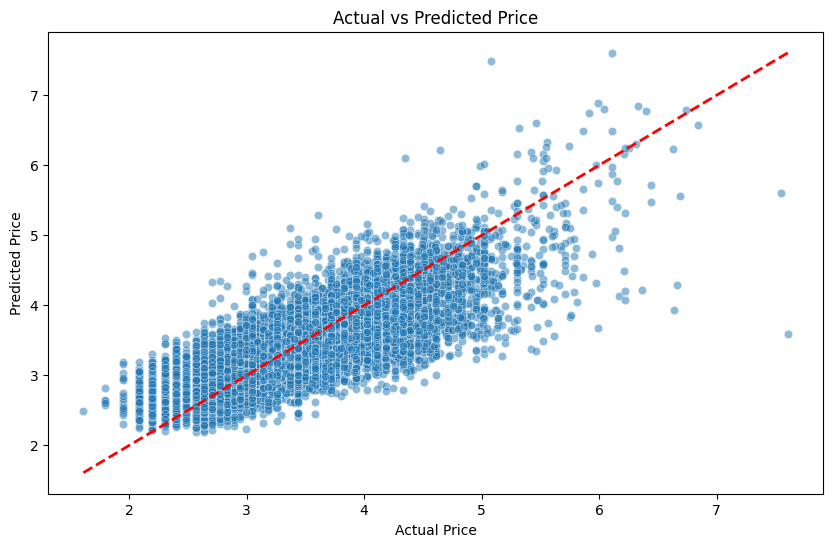

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [11]:
make_regression_model("", CSV_FILEPATH_REALABLE_DATA_FOR_PRICE_REGRESSION_SCALED, False)

## With embeddings

We will stick to logarithmic scale of price because of it's better performance

#### Open AI model

C:\Users\Milosz\AppData\Local\Temp\ipykernel_26524\1007255454.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = np.log1p(df_to_save['price'])


Intercept:  4.247559981156174
Coefficients:  [ 0.01826611 -0.00227385 -0.08827554 ...  0.01293805 -0.09821148
  0.07993226]
   variant      MSE       MAE      MAPE       Rsq
0  1-basic  0.00589  0.059616  0.041047  0.709494


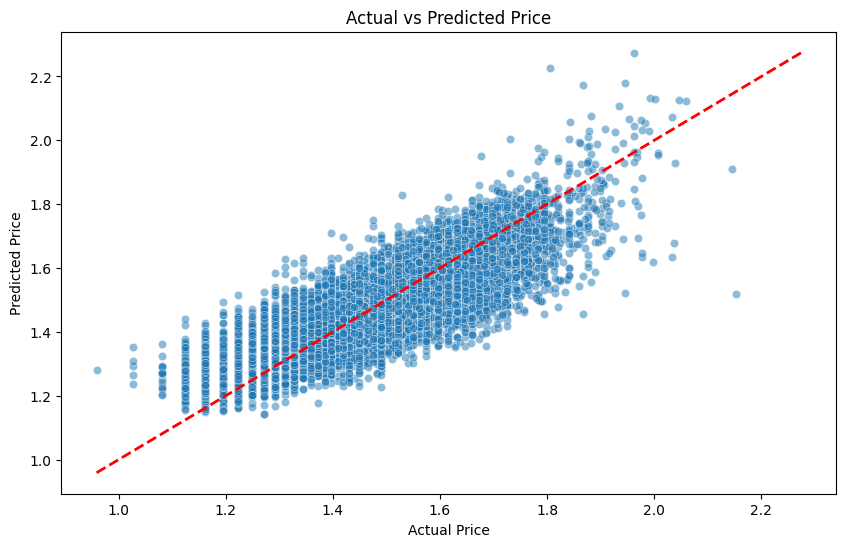

In [11]:
model = make_regression_model(EMBEDEDINGS_FILEPATH_open_ai_api, CSV_FILEPATH_MODEL_READY_DATA_PRICE)

#### We can see that embeddings helps with Price prediction

## Updating data with our linear model

In [20]:
def fill_missing_with_model(df, model, target_column):
    missing_mask = df[target_column].isna()
    to_fill = df[missing_mask].copy()
    to_fill = to_fill.drop(columns = [target_column])
    
    if to_fill.empty:
        print("Brak brakujących wartości.")
        return df

    X_missing = to_fill
    X_missing.columns = X_missing.columns.astype(str)
    predicted_values = model.predict(X_missing)
    predicted_values = np.expm1(predicted_values)
    df.loc[missing_mask, target_column] = predicted_values
    
    return df

In [21]:
df = load_embeddings_and_data(EMBEDEDINGS_FILEPATH_open_ai_api, CSV_FILEPATH_MODEL_READY_DATA_PRICE, isFirstColumnIndex=False)
df['vintage'] = df['vintage'].fillna(df['vintage'].median())
display(df.columns)
display(df['price'])
display(df['price'].isna().sum())
df = fill_missing_with_model(df, model, 'price')
display(df['price'])
display(df['price'].isna().sum())

Index([           'points',           'vintage',    'designation_fe',
               'winery_te',       'region_1_te',        'variety_te',
             'province_te', 'country=Argentina',   'country=Armenia',
       'country=Australia',
       ...
                      1526,                1527,                1528,
                      1529,                1530,                1531,
                      1532,                1533,                1534,
                      1535],
      dtype='object', length=1608)

0          NaN
1         15.0
2         14.0
3         13.0
4         65.0
          ... 
129966    28.0
129967    75.0
129968    30.0
129969    32.0
129970    21.0
Name: price, Length: 129971, dtype: float64

np.int64(8996)

0          3.300587
1         15.000000
2         14.000000
3         13.000000
4         65.000000
            ...    
129966    28.000000
129967    75.000000
129968    30.000000
129969    32.000000
129970    21.000000
Name: price, Length: 129971, dtype: float64

np.int64(0)

In [14]:
df_to_merge = pd.read_csv(CSV_FILEPATH_MODEL_READY_DATA_PRICE)
df_to_merge['price'] = df['price']
df_to_merge['vintage'] = df['vintage']
display(df_to_merge.isna().sum())
df_to_merge.to_csv("winemag-data-130k-v2-fully-preprocessed.csv")

points                          0
vintage                         0
designation_fe                  0
winery_te                       0
region_1_te                     0
                               ..
taster_name=Sean P. Sullivan    0
taster_name=Susan Kostrzewa     0
taster_name=Virginie Boone      0
taster_name=__MISSING__         0
price                           0
Length: 72, dtype: int64